<a href="https://colab.research.google.com/github/abhimshnew/Pneumonia_classification/blob/master/Pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO**

1.   Get data from the kaggle
2.   preprocess the data from the folders
3.   Generate the data set
4.   reize each images to 299×299
5.   get the inceptionv3 model removing the last layer
6.   Add the sutable layer at the output to detect pneumonia or not pneumonia
7.   Get the precision and accuracy score
8.   Try to train some layers in Incepionv3 and see if the accuracy/precision score gets better






In [0]:
import os
import glob
import collections
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load the kaggle attenticaion

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhimshm","key":"852887340af85c7779cafbf907659999"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:34<00:00, 105MB/s] 
100% 2.29G/2.29G [00:34<00:00, 72.3MB/s]


In [6]:
!mkdir chest_xray
!unzip /content/chest-xray-pneumonia.zip -d /content/chest_xray
# !unzip /content/chest_xray/chest_xray.zip -d /content/chest_xray/chest_xray
# Make sure to delet all the unnecessary zip folder to free up the memory

Archive:  /content/chest-xray-pneumonia.zip
  inflating: /content/chest_xray/chest_xray/__MACOSX/._chest_xray  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/._test  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/._train  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: /content/che

In [0]:
# define the directories path for train, test and validation
# here we observe that all the directories have same sub directories namely NORMAL and PNEUMONIA
train_path = '/content/chest_xray/chest_xray/chest_xray/train'
test_path = '/content/chest_xray/chest_xray/chest_xray/test'
valid_path = '/content/chest_xray/chest_xray/chest_xray/val'
dict_results = {'NORMAL':0, 'PNEUMONIA':1}

In [0]:
# Traverse through each image and develop the dataset needed with image as X and 
# Y as classifaction.i.e. Normal as 0 and pneumonia as 1
# Below step will be performaed for all data set hence putting it as a function
from google.colab.patches import cv2_imshow
def generate_data_set(path = None):
    X = []
    Y = []
    assert path is not None, "Please provide the path"
    for each_class in dict_results.keys():
        for each_image in glob.glob(os.path.join(path, each_class)+ "/*.jpeg"):
            img = cv2.imread(each_image)
            X.append(cv2.resize(img, (299,299), cv2.INTER_AREA))
            Y.append(dict_results[each_class])
    return np.array(X), np.array(Y)

X_train, Y_train = generate_data_set(train_path)
X_test, Y_test = generate_data_set(test_path)
X_valid, Y_valid = generate_data_set(valid_path)

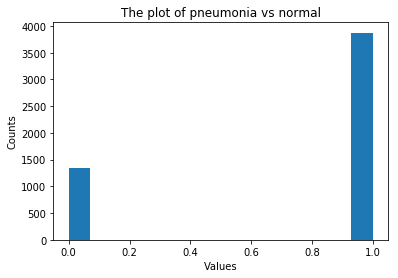

In [0]:
plt.hist(Y_train, bins='auto')
plt.title("The plot of pneumonia vs normal")
plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

The Image resolution is more than 299x299 as required by the inception3 model input layers, Hence need to shrink the image.


In [0]:
print(collections.Counter(Y_valid))

Counter({0: 8, 1: 8})


In [8]:
base_model = InceptionV3(include_top=False, input_shape=(299, 299, 3),
                         pooling='avg')
base_model.trainable = False
base_model.summary()









87916544/87910968 [==============================] - 8s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
______________

In [0]:
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))


**Lets define the opimizer functions**



In [0]:
optimizer=Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 50

It is observed that the loss and acc gets into a repeatative cycle. Hence keeping epoch 50 is enough as I see that the maximum val_acc is 75%

In [0]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

**Data Augmentation and preprocessing**

In [18]:
rescale = 1./255
target_size = (299, 299)
batch_size = 32
class_mode = "categorical"
# class_mode = "binary"


validation_datagen = ImageDataGenerator(rescale=rescale)
test_datagen = ImageDataGenerator(rescale=rescale)

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

# train_generator = train_datagen.flow(X_train, Y_train)
# validation_generator = validation_datagen.flow(X_valid, Y_valid)

# test_generator = validation_datagen.flow(X_test, Y_test)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    class_mode=class_mode,
    shuffle = False)




test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    class_mode=class_mode,
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=epochs,
    verbose=2,
    callbacks=[reduce_lr, early_stopping],
    validation_data=validation_generator,
    validation_steps=len(validation_generator))
print("Model is trained!!!!!")

Epoch 1/50
 - 170s - loss: 0.3613 - acc: 0.8530 - val_loss: 0.9110 - val_acc: 0.5625
Epoch 2/50
 - 160s - loss: 0.2060 - acc: 0.9162 - val_loss: 1.6736 - val_acc: 0.5000
Epoch 3/50
 - 162s - loss: 0.1971 - acc: 0.9210 - val_loss: 0.6399 - val_acc: 0.6250
Epoch 4/50
 - 165s - loss: 0.1625 - acc: 0.9377 - val_loss: 0.7673 - val_acc: 0.5625
Epoch 5/50
 - 167s - loss: 0.1902 - acc: 0.9231 - val_loss: 0.8804 - val_acc: 0.5625
Epoch 6/50
 - 167s - loss: 0.1725 - acc: 0.9316 - val_loss: 0.9594 - val_acc: 0.5625
Epoch 7/50
 - 166s - loss: 0.1626 - acc: 0.9339 - val_loss: 0.6997 - val_acc: 0.5625
Epoch 8/50
 - 166s - loss: 0.1446 - acc: 0.9452 - val_loss: 0.6330 - val_acc: 0.6875
Epoch 9/50
 - 168s - loss: 0.1573 - acc: 0.9362 - val_loss: 0.9320 - val_acc: 0.5000
Epoch 10/50
 - 168s - loss: 0.1629 - acc: 0.9394 - val_loss: 0.8485 - val_acc: 0.5625
Epoch 11/50
 - 167s - loss: 0.1582 - acc: 0.9381 - val_loss: 0.4578 - val_acc: 0.6875
Epoch 12/50
 - 168s - loss: 0.1604 - acc: 0.9356 - val_loss: 0.

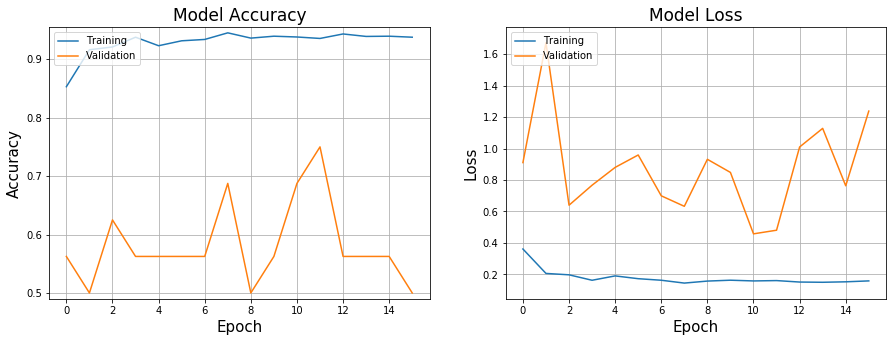

In [20]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [22]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=2)
print("Loss: {}".format(result[0]))
print("Accuracy: {}".format(result[1]))

Loss: 0.6158240500551003
Accuracy: 0.7211538461538461


In [24]:
y_redict = model.predict(X_test)

NameError: ignored